<a href="https://colab.research.google.com/github/evibeq/FaceRecognitionCNN/blob/main/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGGFace
Il modello VGGFace, è stato descritto da Omkar Parkhi, nella tesi del 2015 intitolata "[Deep Face Recognition](https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf)".  
Una parte del documento era una descrizione di come sviluppare un dataset di addestramento molto ampio, necessario per addestrare i moderni sistemi di riconoscimento facciale basati su CNN, per competere con i grandi dataset utilizzati per addestrare i modelli di Facebook e Google.  
Per quanto riguarda la CNN di VGGFace in sé, l'architettura adottata la rende molto profonda, con ben 37 layer, divisi in blocchi di layer convoluzionali con kernel piccoli e attivazioni ReLU seguiti da layer di max pooling con, alla fine del classificatore layer full connected:  
<img src='https://drive.google.com/uc?id=1ppG-bZ_032RiUqWH9IOSN3pRtO1iDO4g'>
 # VGGFace2
In una tesi del 2017 intitolata “[VGGFace2: A dataset for recognising faces across pose and age](https://www.robots.ox.ac.uk/~vgg/publications/2018/Cao18/cao18.pdf)”, Qiong Cao, del VGG, descrive un lavoro di miglioramento del precedente VGGFace.
Descrivono VGGFace2 come un set di dati molto più ampio che hanno raccolto allo scopo di addestrare e valutare modelli di riconoscimento facciale ancora più efficaci.
Il dataset contiene 3,31 milioni di immagini di 9131 soggetti, con una media di 362,6 immagini per ogni soggetto.  
Due dei modelli addestrati su questo dataset, sono ResNet-50 e SqueezeNet-ResNet-50 (chiamato SE-ResNet-50 o SENet), e sono le variazioni di [questi modelli](https://github.com/ox-vgg/vgg_face2) che sono state rese disponibili dagli autori , insieme al codice associato.


# Keras_VGGFace e Face Recognition
Una delle migliori librerie di terze parti per l'utilizzo dei modelli VGGFace2 
(e VGGFace) in Keras è il progetto e la libreria [keras-vggface](https://github.com/rcmalli/keras-vggface) di Refik Can Malli.

In [ ]:
# VGGFace richiede una versione di Tensorflow antecedente alla 2.x
%tensorflow_version 1.x
# Nascondiamo i messaggi di warning che ci consigliano di cambiare versione
import warnings; warnings.simplefilter('ignore')

In [ ]:
# installa la libreria
!pip install keras_vggface

Prima di face recognitioning dobbiamo installare anche una libreria che si occupi di fare face detection. Utilizzeremo [ipazc/MTCNN](https://github.com/ipazc/mtcnn). Per un approfondimento sull'utilizzo guarda questo [colab](https://colab.research.google.com/drive/13gdTneEgbzn0SvvzntR7t2RDhKsvYPZW?usp=sharing).

In [ ]:
# installa la libreria
!pip install mtcnn

In [ ]:
#confermiamo la buona riuscita delle installazioni importando le librerie
from keras_vggface.vggface import VGGFace
import mtcnn

In [ ]:
#collega e monta drive per poter importare le foto su cui fare face detection
from google.colab import drive
drive.mount ('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
import os
from matplotlib import pyplot
# incolla qui il percorso della cartella dove si trovano le foto
dir = '/gdrive/MyDrive/FaceDetection/'

Prima di passare al vero e proprio face recognition dobbiamo prima estrarre la finestra contenente il volto utilizzando MTCNN, per i dettagli controlla questo [colab](https://colab.research.google.com/drive/13gdTneEgbzn0SvvzntR7t2RDhKsvYPZW?usp=sharing).

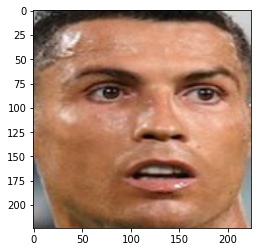

In [ ]:
# example of face detection with mtcnn
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# funzione che estrae una singola faccia da una foto (la prima che trova)
def extract_face(filename, required_size=(224, 224)):
	# carica l'immagine
	pixels = pyplot.imread(filename)
	# crea il detector, usando i pesi di default
	detector = MTCNN()
	# rileva le faccie nell'immagine
	results = detector.detect_faces(pixels)
	# estrae gli attributi del bounding box
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height
	# estrae la faccia
	face = pixels[y1:y2, x1:x2]
	# scala i pixel per rendere l'immagine conforme alle dimensioni del model
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# carica l'immagine e estrae la faccia
pixels = extract_face(dir + '1.jpg')
# plotta la faccia estratta
pyplot.imshow(pixels)
# mostra il plot
pyplot.show()

`model = VGGFace(model='...')` permette di creare un modello VGGFace, specificandone il tipo attraverso l'argomento `model`.  
La libreria `keras-vggface` propone tre modelli pre-addestrare:  
`vgg16` corrisponde a VGGFace1 ed è la scelta di default;  
`resnet50` presentata con VGGFace2, con una profondità di 50 layers;  
`senet50` presentata con VGGFace2, la più potente delle 3.  
Utilizziamo pertanto l'ultima anche se non sempre risulta la migliore con determinate foto. Questo passaggio richiede di scaricare 175 MB.


In [ ]:
# crea il modello vggface2
model = VGGFace(model='senet50')

La capacità di predirre l'appartenenza di un volto ad una data celebrità tra i 9131 del dataset è affidata a `model.predict()`  
Una volta fatta la predizione i risultati vengono mappati sui nomi delle celebrità e le 5 con la probabilità più alta vengono rese note da `decode_prediction`.

In [ ]:
from numpy import expand_dims
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions

# converte la faccia in campioni
pixels = pixels.astype('float32')
samples = expand_dims(pixels, axis=0)
# prepara la faccia per il modello (es: centrando i pixel)
samples = preprocess_input(samples, version=2)
# crea una predizione
predictions = model.predict(samples)
# converte la predizione in nomi
results = decode_predictions(predictions)
# mostra i 5 risultati migliori
for result in results[0]:
	print('%s: %.3f%%' % (result[0], result[1]*100))

b' Cristiano_Ronaldo': 92.288%
b' Gonzalo_Fierro': 6.608%
b' Gonzalo_Jara': 0.274%
b' Marcos_Mondaini': 0.207%
b' Paul_Aguilar': 0.164%


#Face verification con VGGFace2
VGGFace2 può essere utilizzato anche per la face verification. Ciò comporta estrarre le informazioni da una foto contenente una nuova faccia e compararle con le informazioni contenuto nel sistema. Queste informazioni sono rappresentate da un vettore contenente le caratteristiche estratte dal volto. Questo vettore può quindi essere confrontato con un altro vettore, e, se quindi si somigliano, potrebbero rappresentare la stessa persona. Distanze tipiche come la distanza euclidea e la distanza del coseno vengono calcolate tra i due vettori e se si trovano sotto una certa soglia danno esito affermativo.  
Per fare face verification con VGGFace stavolta creiamo il modello senza includere il classificatore di default con `include_top=False` e settando `pooling='avg'` cosichè l'output sia ridotto a un vettore usando il global average pooling.



In [ ]:
# creiamo il modello
model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

Positive Tests
>face is a Match (0.306 <= 0.500)
>face is a Match (0.236 <= 0.500)
Negative Tests
>face is NOT a Match (0.709 > 0.500)


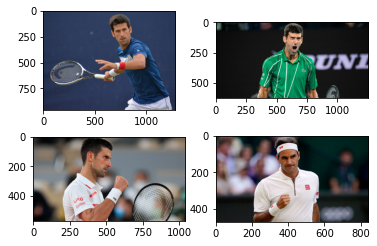

In [ ]:
from scipy.spatial.distance import cosine
 
# funzione che estrae le facce e definisce le informazioni di ognuna di esse
def get_embeddings(filenames):
	# estrae le facce, funzione definita sopra
	faces = [extract_face(f) for f in filenames]
	# converte le faccie in un array di campioni
	samples = asarray(faces, 'float32')
	# prepara le facce per il modello
	samples = preprocess_input(samples, version=2)
	# crea una predizione
	predictions = model.predict(samples)
	return predictions
 
# funzione che determina se una faccia fa match con una faccia già nota
def is_match(known_embedding, candidate_embedding, thresh=0.5):
	# calcola la distanza tra i vettori di informazioni
	score = cosine(known_embedding, candidate_embedding)
	if score <= thresh:
		print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
	else:
		print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))
 
# definisce filenames (mettere come prima tra le 4 immagini quella su cui fare i confronti)
filenames = [dir + 'djokovic1.jpg',dir + 'djokovic2.jpg',dir +
	'djokovic3.jpg',dir + 'federer.jpg']
#crea figura e sublopts per ogni immagine
figure = pyplot.figure()
for index, image in enumerate(filenames):
  pixels = pyplot.imread(image)
  ax = figure.add_subplot(2,2,index+1)
  ax.imshow(pixels)
# crea informazioni a partire dai file
embeddings = get_embeddings(filenames)
# verifica foto della stessa persona
print('Positive Tests')
is_match(embeddings[0], embeddings[1])
is_match(embeddings[0], embeddings[2])
# verifica foto di un'altra persona
print('Negative Tests')
is_match(embeddings[0], embeddings[3])